<a href="https://colab.research.google.com/github/shekhar-hazari/CML-Assignment-2/blob/main/Luke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
In this task a cancer cell detection system will be created.

Luke Mason - s3630120 \
Shekhar Hazari - s3831855

## Setup

### Import packages

In [69]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

### Initialise helper functions¶

In [2]:
def holdout_validation(train_size, X, Y):
    
    # Get the difference between train and test size, together both make 100% of the raw data set.
    test_size = 1 - train_size
    
    # Split into train and test for normal and target fields set, left overs are for validation and test.
    with pd.option_context('mode.chained_assignment', None):
        train_X, X_test_, train_Y, Y_test_ = train_test_split(X, Y, test_size=test_size, shuffle=True,random_state=0)

    # Split the test data into validation test and test.
    # Do for target field and normal fields.
    with pd.option_context('mode.chained_assignment', None):
         val_X, test_X, val_Y, test_Y = train_test_split(X_test_, Y_test_, test_size=0.5, shuffle=True, random_state=29)
    return train_X, val_X, test_X, train_Y, val_Y, test_Y

def hist_plot(title, columns, colours, nrows, ncols, index_pos, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3, hspace=0.7):
    """
    Plots a histogram.
    :param title:     The title of the histogram.
    :param columns:   The data columns to plot on the histogram.
    :param colours:   The colours for each data column on the histogram.
    :param nrows:     The number of rows in the presentation table.
    :param ncols:     The number of columns in the presentation table.
    :param index_pos: The index of the histogram on the
    :param left:      How far to move away from left.
    :param top:       How far to move away from top.
    :param bottom:    How far to extend towards bottom.
    :param right:     How far to extend boundary towards right.
    :param wspace:    Height ratio spacing between plots.
    :param hspace:    Width ratio spacing between plots.
    :return:
    """
    plt.subplot(nrows,ncols,index_pos)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    for index_pos, column in enumerate(columns):
        plt.hist(column, alpha=0.3, color=colours[index_pos % len(colours)], density=True)
    plt.title(title)
    plt.xticks(rotation='vertical')

def train_val_test_split_by_column(dataframe, column, train_size = 0.666, val_size = 0.5):
  splitting_IDs = dataframe[column].unique()
  train_IDs, test_IDs = train_test_split(splitting_IDs, train_size = train_size)
  val_IDs, test_IDs = train_test_split(test_IDs, train_size = val_size)

  train_IDs = pd.DataFrame(train_IDs)
  train_IDs.rename(columns = {0:column}, inplace = True)
  train_IDs['split'] = 'train'

  val_IDs = pd.DataFrame(val_IDs)
  val_IDs.rename(columns = {0:column}, inplace = True)
  val_IDs['split'] = 'validation'

  test_IDs = pd.DataFrame(test_IDs)
  test_IDs.rename(columns = {0:column}, inplace = True)
  test_IDs['split'] = 'test'

  splits = pd.concat([train_IDs, val_IDs, test_IDs], ignore_index=True)

  dataframe = pd.merge(dataframe, splits, on = column)

  train_set = dataframe[dataframe['split'] == 'train']
  train_set = train_set.drop(['split'], axis = 1)

  validation_set = dataframe[dataframe['split'] == 'validation']
  validation_set = validation_set.drop(['split'], axis = 1)

  test_set = dataframe[dataframe['split'] == 'test']
  test_set = test_set.drop(['split'], axis = 1)

  return train_set, validation_set, test_set

def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### Unzip zipped data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Change according to your directory structure
!cp /content/drive/'My Drive'/CML-Assignment-2/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


### Load the data
This data contains both the cell type and isCancerous labels.

In [5]:
main_data = pd.read_csv('./data_labels_mainData.csv', delimiter=',')
extra_data = pd.read_csv('./data_labels_extraData.csv', delimiter=',')

## 1 - Exploratory Data Analysis
The data is assumed to be made of entirely by newborn babies according to the assignment forums.\

### 1.1 - Main Data Set

#### 1.1.1 - Splitting the data
Splitting the main dataset into train, validation and test sets

In [37]:
main_train_set, main_validation_set, main_test_set = train_val_test_split_by_column(main_data, 'patientID')

In [38]:
print('Overall ferquency of isCancerous:')
print(main_data.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in training data: ')
print(main_train_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in validation data: ')
print(main_validation_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in test data: ')
print(main_test_set.isCancerous.value_counts().to_frame())

Overall ferquency of isCancerous:
   isCancerous
0         5817
1         4079
Frequency of isCancerous in training data: 
   isCancerous
0         3659
1         2409
Frequency of isCancerous in validation data: 
   isCancerous
0         1020
1          671
Frequency of isCancerous in test data: 
   isCancerous
0         1138
1          999


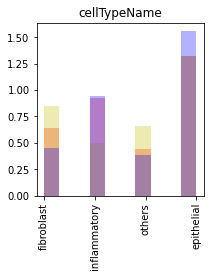

In [43]:
# Graph the results
plt.figure(figsize=(3,3))
col = "cellTypeName"
hist_plot(col, [main_train_set[col], main_validation_set[col], main_test_set[col]], ['r', 'y', 'b'], 1, 1, 1)

🧐 **Observations:**
> - Epithelial cell type is evenly distributed over the train, validation and test set, but the other types are not.

👨🏻‍🎓 **Conclusions**
> - 

#### 1.1.2 - Preview
Previewing the contents of the main data set.

In [6]:
main_data.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [7]:
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [8]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [54]:
df1 = main_data.groupby(['cellTypeName', 'cellType'])['InstanceID'].nunique()
df2 = main_data.groupby(['isCancerous'])['InstanceID'].nunique()
print(df1)
print(df2)

cellTypeName  cellType
epithelial    2           4079
fibroblast    0           1888
inflammatory  1           2543
others        3           1386
Name: InstanceID, dtype: int64
isCancerous
0    5817
1    4079
Name: InstanceID, dtype: int64


🧐 **Observations:**
> - The different columns have different data typees and is not uniform
> - ImageName contains the image file name the results reference
> - isCancerous is the main target column
> - cellType is likely the secondary target column, and derived from isCancerous, and not the vice versa.
> - cellType is the encoded version of cellTypeName

👨🏻‍🎓 **Conclusions**
> - Make the data types over the dataset uniform, either into type string or object.
> - Use cellType instead of the cellTypeName
> - 

Preview the image data via cell type

In [56]:
label_names = {k: v for k, v in df1.keys()}
cellTypes = {v: k for k, v in label_names.items()}
print(label_names)
print(cellTypes)

{'epithelial': 2, 'fibroblast': 0, 'inflammatory': 1, 'others': 3}
{2: 'epithelial', 0: 'fibroblast', 1: 'inflammatory', 3: 'others'}


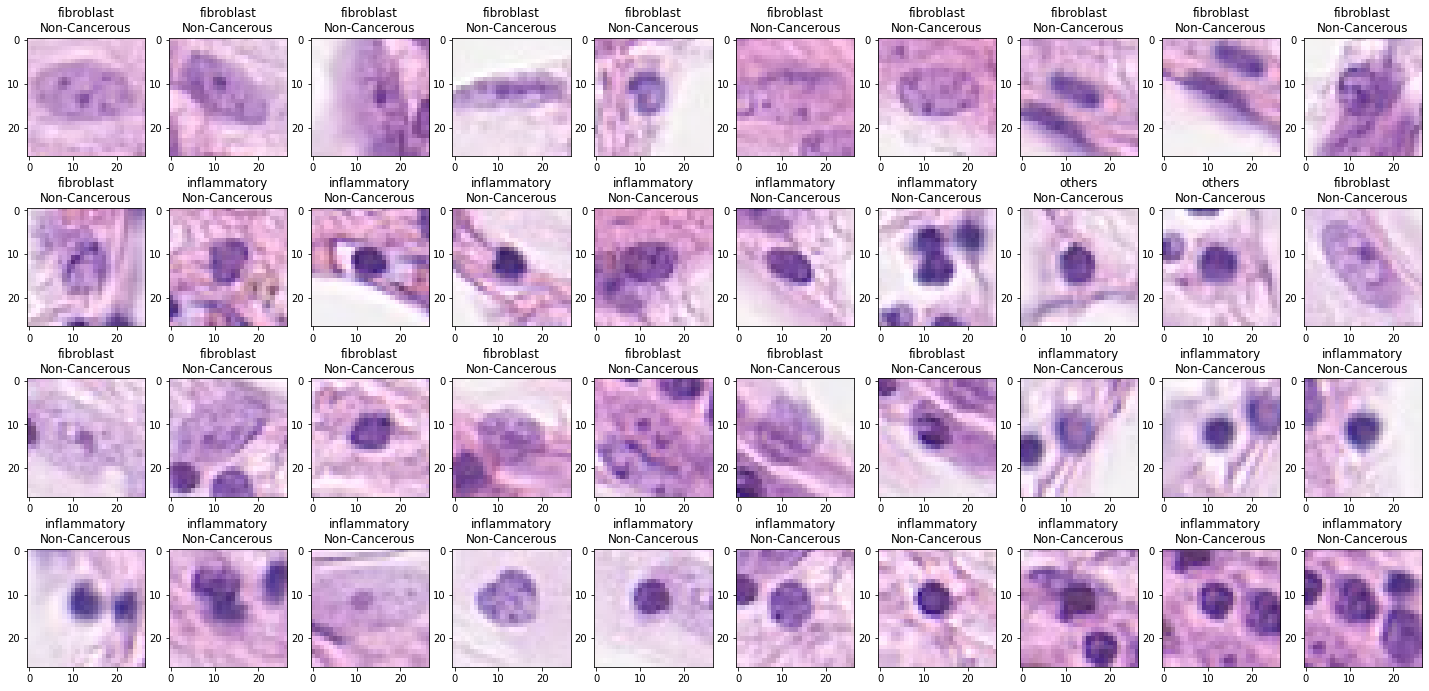

In [58]:
img_list = list(main_train_set["ImageName"])
types = list(main_train_set["cellType"])
target_list = list(main_train_set["isCancerous"])
target_labels = {1: "Cancerous", 0: "Non-Cancerous"}

plt.figure(figsize=[25,12])

for i in np.arange(40):
  plt.subplot(4, 10, i + 1)
  img = Image.open('./patch_images/' + img_list[i])

  plt.imshow(img)
  plt.title(cellTypes[types[i]] + "\n" + target_labels[target_list[i]])

In [60]:
# Check image sizes
img = Image.open('./patch_images/' + img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print("Image size: \nH:{} W:{} C:{}".format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size: 
H:27 W:27 C:3


🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

#### 1.1.3 - Transformation
Set all types to be of type Object. We do this because all the variables are categorical, they don't have any continuous values, so it's easier while creating visualizations.

In [ ]:
for column in main_data.columns:
  main_data[column] = main_data[column].astype('object')

In [ ]:
print(main_data.info())

In [ ]:
main_data.describe(include=['object'])

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

#### 1.1.4 - Examination
Examining the data's distribution via bucketing the categories.



In [ ]:
pd.crosstab(main_data['cellTypeName'], main_data['isCancerous'], margins = False).plot.bar(stacked = True,
                                                                                            title = 'Frequency of cell types',
                                                                                            xlabel = 'Cell Type',
                                                                                            ylabel = 'Number of Images')

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

In [ ]:
main_data.patientID.value_counts().nlargest(5).to_frame().plot(kind = 'bar', title = 'Top 5 Patients by number of images',
                                                               xlabel = 'Patient ID', ylabel = 'Number of images', legend = False,
                                                               label = True)

In [ ]:
main_data.patientID.value_counts().nsmallest(5).to_frame().plot(kind = 'bar', title = 'Bottom 5 Patients by number of images',
                                                                xlabel = 'Patient ID', ylabel = 'Number of images', legend = False)

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

### 1.2 - Extra Data Set

#### 1.2.1 - Splitting the data

In [40]:
extra_train_set, extra_validation_set, extra_test_set = train_val_test_split_by_column(extra_data, 'patientID')

In [41]:
print('Overall ferquency of isCancerous:')
print(extra_data.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in training data: ')
print(extra_train_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in validation data: ')
print(extra_validation_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in test data: ')
print(extra_test_set.isCancerous.value_counts().to_frame())

Overall ferquency of isCancerous:
   isCancerous
0         7394
1         2990
Frequency of isCancerous in training data: 
   isCancerous
0         5881
1         1852
Frequency of isCancerous in validation data: 
   isCancerous
0          767
1          226
Frequency of isCancerous in test data: 
   isCancerous
1          912
0          746


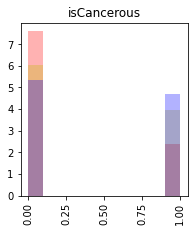

In [46]:
# Graph the results
plt.figure(figsize=(3,3))
col = "isCancerous"
hist_plot(col, [extra_train_set[col], main_validation_set[col], main_test_set[col]], ['r', 'y', 'b'], 1, 1, 1)

🧐 **Observations:**
> - There is very little cancerous cells in the train set, but a lot of non cancerous cells in the train set.
> - 

👨🏻‍🎓 **Conclusions**
> - 

In [ ]:
extra_data.describe()

In [ ]:
extra_data.head()

In [ ]:
extra_data.info()

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

#### 1.2.2 - Preview
Previewing the contents of the main data set.

In [ ]:
extra_data.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [ ]:
extra_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [ ]:
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [61]:
df = extra_data.groupby(['isCancerous'])['InstanceID'].nunique()
print(df)

isCancerous
0    7394
1    2990
Name: InstanceID, dtype: int64


🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

Preview the image data via cell type

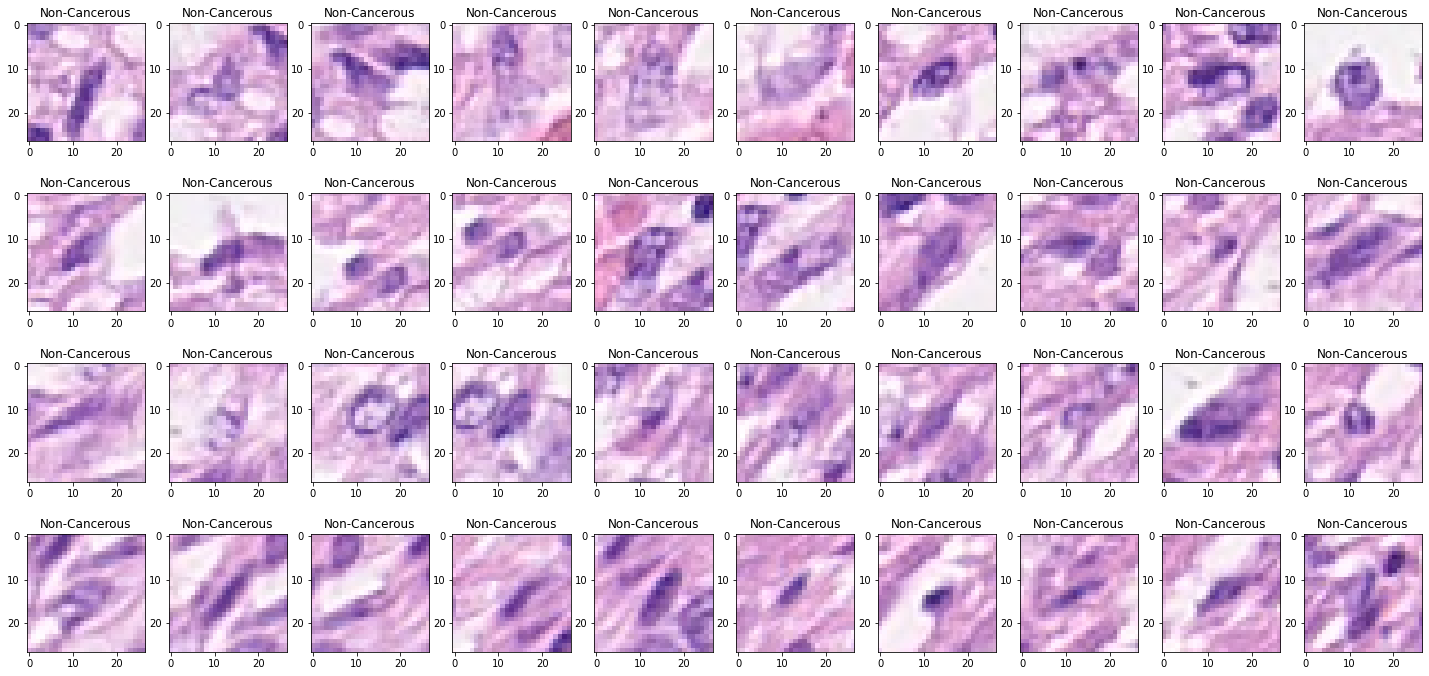

In [63]:
img_list = list(extra_train_set["ImageName"])
target_list = list(extra_train_set["isCancerous"])
target_labels = {1: "Cancerous", 0: "Non-Cancerous"}

plt.figure(figsize=[25,12])

for i in np.arange(40):
  plt.subplot(4, 10, i + 1)
  img = Image.open('./patch_images/' + img_list[i])

  plt.imshow(img)
  plt.title(target_labels[target_list[i]])

In [64]:
# Check image sizes
img = Image.open('./patch_images/' + img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print("Image size: \nH:{} W:{} C:{}".format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size: 
H:27 W:27 C:3


🧐 **Observations:**
> - Images are 27 x 27 x 3

👨🏻‍🎓 **Conclusions**
> - 

#### 1.2.3 - Transformation
Set all types to be of type Object. We do this because all the variables are categorical, they don't have any continuous values, so it's easier while creating visualizations.

In [70]:
for column in extra_data.columns:
  extra_data[column] = extra_data[column].astype('object')

In [71]:
print(extra_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  object
 1   patientID    10384 non-null  object
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  object
dtypes: object(4)
memory usage: 324.6+ KB
None


In [72]:
extra_data.describe(include=['object'])

,InstanceID,patientID,ImageName,isCancerous
count,10384,10384,10384,10384
unique,10384,38,10384,2
top,16383,79,9564.png,0
freq,1,699,1,7394


🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

In [73]:
extra_data.describe()

,InstanceID,patientID,ImageName,isCancerous
count,10384,10384,10384,10384
unique,10384,38,10384,2
top,16383,79,9564.png,0
freq,1,699,1,7394


In [74]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [75]:
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  object
 1   patientID    10384 non-null  object
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  object
dtypes: object(4)
memory usage: 324.6+ KB


🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

#### 1.2.4 - Examination

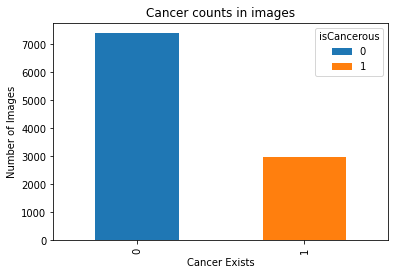

In [76]:
pd.crosstab(extra_data['isCancerous'], extra_data['isCancerous'], margins = False).plot.bar(stacked = True,
                                                                                            title = 'Cancer counts in images',
                                                                                            xlabel = 'Cancer Exists',
                                                                                            ylabel = 'Number of Images')

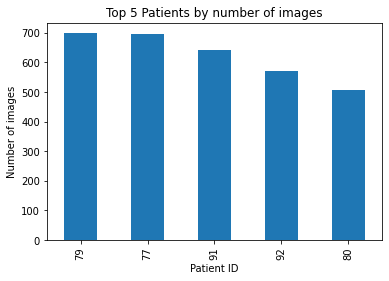

In [77]:
extra_data.patientID.value_counts().nlargest(5).to_frame().plot(kind = 'bar', title = 'Top 5 Patients by number of images',
                                                               xlabel = 'Patient ID', ylabel = 'Number of images', legend = False,
                                                               label = True)

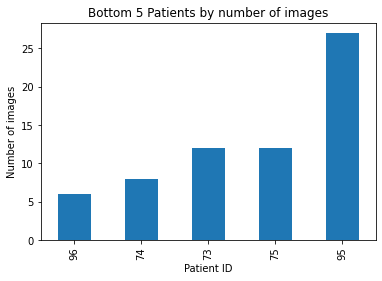

In [78]:
extra_data.patientID.value_counts().nsmallest(5).to_frame().plot(kind = 'bar', title = 'Bottom 5 Patients by number of images',
                                                                xlabel = 'Patient ID', ylabel = 'Number of images', legend = False)

## 2 - Feature Selection

## 3 - Modelling 

In [79]:
# Initialise Constants
INPUT_DIM = (27,27,3)
OUTPUT_CLASSES = 2

### 3.1 - MLP

In [81]:
# initial_hyper_parameters
hp = {
  "hidden_layer_dim": 256,
  "optimizer": 'SGD', # TODO try "Adam"
  "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True), # TODO try "mse"
  "metrics": ['categorical_accuracy'], # TODO try "mae"
  "epochs": 50,
  "batch_size": 32
}

# The Deep Neural Network Layer Structure
initial_nn = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(hp["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(hp["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
]

# 
# AUTOTUNE = tf.data.experimental.AUTOTUNE


In [84]:
model = tf.keras.Sequential(initial_nn)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 626,434
Trainable params: 626,434
Non-trainable params: 0
_________________________________________________________________


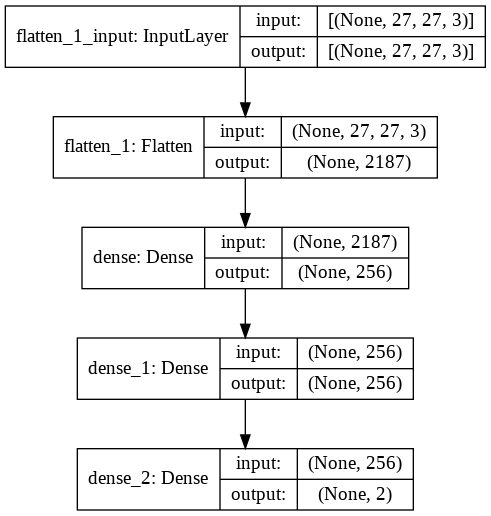

In [85]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [87]:
# Make isCancerous target feature string so that the categorical class_mode can categorise it.
main_train_set['isCancerous'] = main_train_set['isCancerous'].astype('str')
main_validation_set['isCancerous'] = main_validation_set['isCancerous'].astype('str')

In [88]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_generator = train_datagen.flow_from_dataframe(
        dataframe=main_train_set,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=hp["batch_size"],
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=main_validation_set,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=hp["batch_size"],
        class_mode='categorical')

Found 6068 validated image filenames belonging to 2 classes.
Found 1691 validated image filenames belonging to 2 classes.


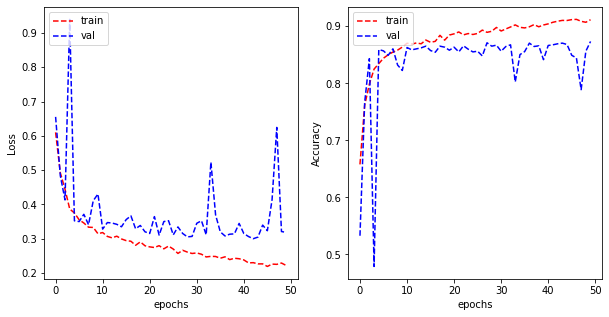

In [90]:
model.compile(optimizer=hp["optimizer"], loss=hp["loss"], metrics=hp["metrics"])
history = model.fit(train_generator, validation_data = validation_generator, epochs=hp["epochs"], verbose=0)
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=main_test_set,
        directory='./',
        x_col="ImgPath",
        y_col="Class",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.evaluate(test_generator)

Deep Learning HOG CV - Shekhar

CNN

In [ ]:
# CNN
# model_VGG_3 = tf.keras.Sequential([
#     #VGG block 1
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 2
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 3
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
    
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Dense(OUTPUT_CLASSES),
# ])

# Save model
# model_VGG_3.save("model_VGG_3")

Investigate Other Techniques hopefully OP

Explore how the data in both tasks can be used to improve the cell-type classification